In [1]:
from google.colab import drive
drive.mount('/content/drive')
!ls drive/My\ Drive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
lgbm_submission.csv  submission.csv	     VSB_mid_yields
model1.hdf5	     TGSsalt0.ipynb	     vsb_power_line.ipynb
pytorch_iris.ipynb   TGSsalt_for_demo.ipynb


In [3]:
!pip3 install torch

    100% |████████████████████████████████| 591.8MB 28kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x610a8000 @  0x7f49956bb2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [5]:
!pip3 install torchvision

    100% |████████████████████████████████| 61kB 2.1MB/s 
    100% |████████████████████████████████| 2.0MB 13.7MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
  [PIL]
You must restart the runtime in order to use newly installed versions.


In [6]:
!pip3 install tqdm

In [0]:
import datetime
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from sklearn.model_selection import train_test_split

In [0]:
import random
import os

SEED = 1029

def seed_everything(seed=1029):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [44]:
class NN(torch.nn.Module):
  def __init__(self, in_size, hidden_size, out_size):
    super(NN, self).__init__()
    self.xh = torch.nn.Linear(in_size, hidden_size)
    self.hh = torch.nn.Linear(hidden_size, hidden_size)
    self.hy = torch.nn.Linear(hidden_size, out_size)
    
  def __call__(self, x):
    h = F.relu(self.xh(x))
    h = F.relu(self.hh(h))
    y = F.log_softmax(self.hy(h))
    return y
  
# learning
  
EPOCH_NUM = 100
HIDDEN_SIZE = 20
BATCH_SIZE = 20
  
#data
  
N = 100
in_size = 4
out_size = 3
iris = load_iris()
data = pd.DataFrame(data = np.c_[iris["data"], iris["target"]], columns= iris["feature_names"] + ["target"])
data = np.array(data.values)
perm = np.random.permutation(len(data))
data = data[perm]
train, test = np.split(data, [N])
train_x, train_y, test_x, test_y = [], [], [], []
for t in train:
    train_x.append(t[0:4])
    train_y.append(t[4])
for t in test:
    test_x.append(t[0:4])
    test_y.append(t[4])
train_x = np.array(train_x, dtype="float32")
train_y = np.array(train_y, dtype="int64")
test_x = np.array(test_x, dtype="float32")
test_y = np.array(test_y, dtype="int64")
train_x = torch.from_numpy(train_x)
train_y = torch.from_numpy(train_y)
test_x = torch.from_numpy(test_x)
test_y = torch.from_numpy(test_y)

print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

#dataloader
train = torch.utils.data.TensorDataset(train_x,  train_y)
train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)

#define model
model = NN(in_size=in_size, hidden_size=HIDDEN_SIZE, out_size=out_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
  

torch.Size([100, 4]) torch.Size([100]) torch.Size([50, 4]) torch.Size([50])


In [45]:
#start learning
print("Train")
st = datetime.datetime.now()
train_losses = []
for epoch in range(EPOCH_NUM):
  # mini batch
  total_loss = 0
  for i, data in enumerate(train_loader):
    x, y = data
    x, y = Variable(x), Variable(y)
    optimizer.zero_grad()
    y_ = model(x)
    loss = criterion(y_, y)
    total_loss += loss.data.item()
    loss.backward()
    optimizer.step()
  train_losses.append(loss.item())
  if(epoch+1) % 10 == 0:
    #acc
    x, y = Variable(train_x), Variable(train_y)
    _, y_ = torch.max(model(x).data, 1)
    accuracy = sum(y.data.numpy() == y_.numpy()) / N
    # test acc
    x, y = Variable(test_x), Variable(test_y)
    _, y_ = torch.max(model(x).data, 1)
    test_accuracy = sum(y.data.numpy() == y_.numpy()) / len(y.data.numpy())
    ed = datetime.datetime.now()
    print("epoch:\t{}\ttotal loss:\t{}\taccuracy:\t{}\tvaridation accuracy\t{}\ttime:\t{}".format(epoch+1, total_loss, accuracy, test_accuracy, ed-st))
    st = datetime.datetime.now()

Train
epoch:	10	total loss:	4.794396281242371	accuracy:	0.72	varidation accuracy	0.6	time:	0:00:00.056471
epoch:	20	total loss:	3.633681535720825	accuracy:	0.95	varidation accuracy	1.0	time:	0:00:00.060633
epoch:	30	total loss:	2.6056481301784515	accuracy:	0.88	varidation accuracy	1.0	time:	0:00:00.056537


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


epoch:	40	total loss:	2.031888395547867	accuracy:	0.96	varidation accuracy	1.0	time:	0:00:00.057110
epoch:	50	total loss:	1.6242728233337402	accuracy:	0.96	varidation accuracy	1.0	time:	0:00:00.051306
epoch:	60	total loss:	1.3222915530204773	accuracy:	0.97	varidation accuracy	1.0	time:	0:00:00.054085
epoch:	70	total loss:	1.080779790878296	accuracy:	0.97	varidation accuracy	1.0	time:	0:00:00.051514
epoch:	80	total loss:	0.9343184605240822	accuracy:	0.96	varidation accuracy	1.0	time:	0:00:00.052825
epoch:	90	total loss:	0.8081510215997696	accuracy:	0.96	varidation accuracy	1.0	time:	0:00:00.049797
epoch:	100	total loss:	0.7423260062932968	accuracy:	0.96	varidation accuracy	1.0	time:	0:00:00.049635


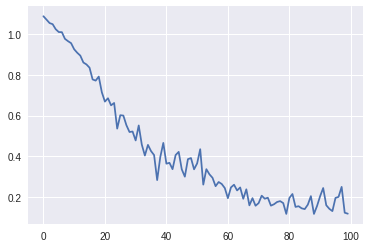

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(train_losses)

In [47]:
# predict

print("Predict")
print("x\ty\tpredict")

idx = np.random.choice(len(iris.data)-N, 10)
for i in idx:
  x, y = test_x[i], test_y[i]
  y_ = model(x = Variable(x.view(1, len(x)))).data
  _, y_ = torch.max(y_, 1)
  print(x.numpy(), "\t", y, "\t", y_[0])

Predict
x	y	predict
[6.7 3.3 5.7 2.1] 	 tensor(2) 	 tensor(2)
[6.4 2.9 4.3 1.3] 	 tensor(1) 	 tensor(1)
[5.6 2.9 3.6 1.3] 	 tensor(1) 	 tensor(1)
[4.4 3.2 1.3 0.2] 	 tensor(0) 	 tensor(0)
[5.7 2.5 5.  2. ] 	 tensor(2) 	 tensor(2)
[6.9 3.1 4.9 1.5] 	 tensor(1) 	 tensor(1)
[5.1 3.3 1.7 0.5] 	 tensor(0) 	 tensor(0)
[6.7 3.1 4.7 1.5] 	 tensor(1) 	 tensor(1)
[6.8 3.  5.5 2.1] 	 tensor(2) 	 tensor(2)
[5.7 2.5 5.  2. ] 	 tensor(2) 	 tensor(2)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()
